In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as r

In [2]:
# Some values in a_max were too large for a 64-bit number
# In the training code, I used a 128-bit float to store them
# However, the library I'm using here to create the correlation
# graphs doesn't support 128-bit floats. So instead I'll use this
# function to change those massive values to the max value of a
# unsigned 64-bit int (fine for this purpose)
def handle_overflow_vals(x):
    max_val = np.iinfo(np.uint64).max
    max_len = len(str(max_val))
    x_len = len(x)

    # If the length of string representation
    # of the int is shorter than max, we know
    # it has a lesser value
    if x_len < max_len: return np.uint64(x)
    
    # If the length is greater, it must have a
    # greater value. Hence we return the max val
    if x_len > max_len: return max_val

    # Otherwise, their lengths are equal. The int
    # could still be greater, but we can't cast it
    # to an int as we would risk the overflow this
    # function intends to prevent. Hence we compare
    # the strings directly. Since they're the same
    # length, this will tell us which is larger
    if x < str(max_val): return np.uint64(x)
    else: return max_val

In [3]:
# Read in feature sets and corresponding outputs
# Some values of a_max were too large for a 64-bit number,
# so a 128-bit float had to be specified in order for the
# column to be parsed correctly (otherwise Pandas defaulted
# to parsing them as strings)
X1 = pd.read_csv("features_idl.csv")
X2 = pd.read_csv("features_lia.csv",converters={'a_max':handle_overflow_vals})
y1 = pd.read_csv("best_solver_idl.csv")
y2 = pd.read_csv("best_solver_lia.csv")

In [4]:
# Get feature sets for QF_LIA 
X_time = X2.values
y_time = pd.read_csv("times_sat_lia.csv")
y_time = np.squeeze(y_time.values)

In [5]:
# Convert output values to 0 for lazy, or 1 for eager
y1 = y1.values
y1 = pd.DataFrame(np.where(y1 == "sat", 0, np.where(y1 == "z3", 1, np.where(y1 == "cvc4", 1, -1))))

y2 = y2.values
y2 = pd.DataFrame(np.where(y2 == "sat", 0, np.where(y2 == "z3", 1, np.where(y2 == "cvc4", 1, -1))))

# Verifies that there were no values in the data other than "cvc4", "z3", or "sat"
assert(not -1 in y1.values)
assert(not -1 in y2.values)

In [6]:
# Combine data from IDL and LIA datasets
X = pd.concat([X1,X2])
y = pd.concat([y1,y2])

header = X.columns

X = X.values
y = np.squeeze(y.values)

In [7]:
# For each feature, compute correlation of feature and whether eager or lazy was best
# If the p-value indicates statistical significance (p <= 0.05), print it
for i in range(X.shape[1]):
    R, P = r(X[:,i],y)
    if P <= 0.05:
        print("Feature " + str(i) + ": (" + header[i] + ") r=" + str(R) + ", p=" + str(P))

Feature 2: (a_max) r=-0.3192918854691018, p=5.0798665725391125e-06
Feature 6: (bound) r=-0.31093274861021897, p=9.179000252769927e-06


In [8]:
# For each feature, compute correlation of feature and time for eager to solve
# If the p-value indicates statistical significance (p <= 0.05), print it
for i in range(X_time.shape[1]):
    R, P = r(X_time[:,i],y_time)
    if P <= 0.05:
        print("Feature " + str(i) + ": (" + header[i] + ") r=" + str(R) + ", p=" + str(P))

Feature 0: (vars) r=0.5422816933078599, p=9.63253129445331e-09
Feature 1: (constraints) r=0.5323908157193543, p=1.9930906645476565e-08
Feature 3: (b_max) r=0.32523099625113333, p=0.0011521242301819263
Feature 4: (k) r=-0.33863627730652535, p=0.0006919027060769139
Feature 6: (bound) r=-0.22464687827852514, p=0.0269535405270737


In [10]:
# Where i is the feature index
def show_correlation_graph_eager_lazy(i):
    x = X[:,i]
    plt.scatter(x,y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r-")

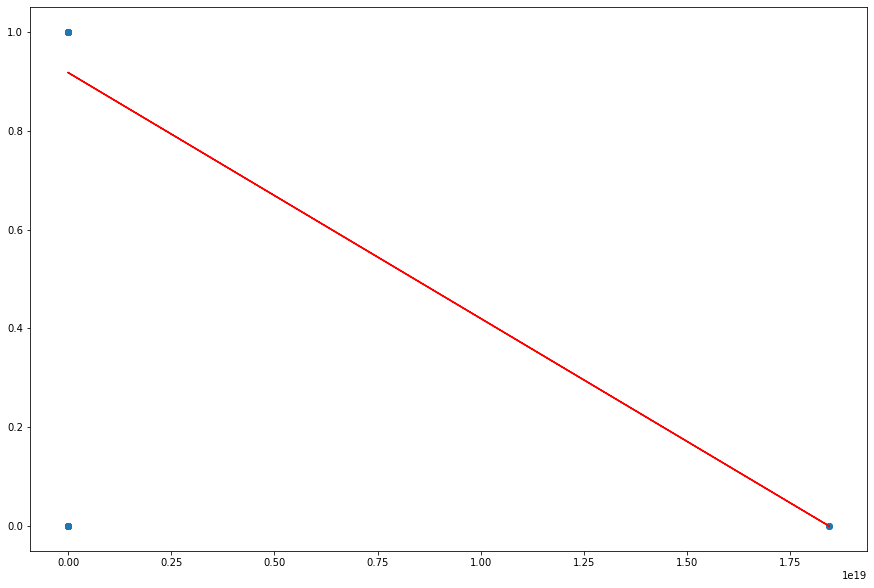

In [27]:
# a_max vs. eager (0) lazy (1)
fig = plt.figure(figsize=(15,10))
show_correlation_graph_eager_lazy(2)

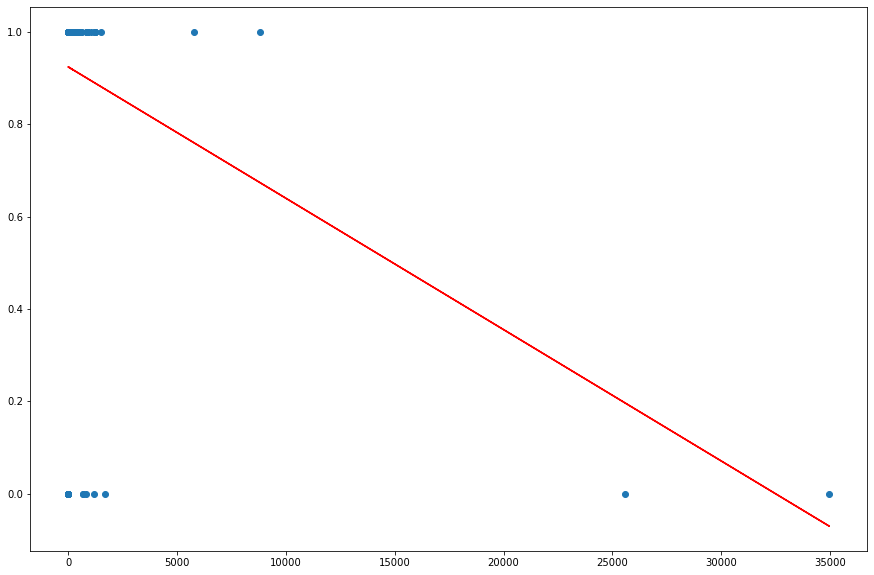

In [28]:
# bound vs. eager (0) lazy (1)
fig = plt.figure(figsize=(15,10))
show_correlation_graph_eager_lazy(6)

In [13]:
# Where i is the feature index
def show_correlation_graph_time(i):
    x = X_time[:,i]
    plt.scatter(x,y_time)
    z = np.polyfit(x, y_time, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r-")

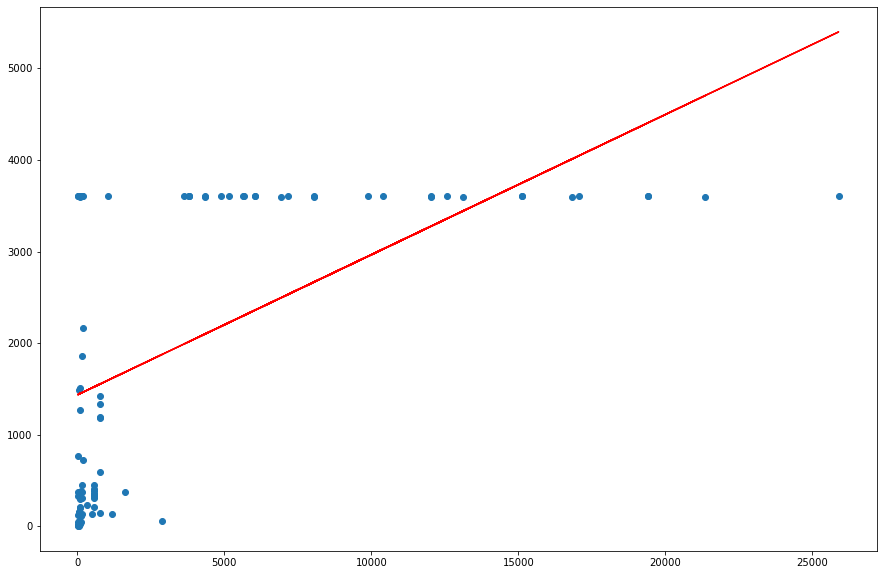

In [29]:
# vars vs. time
fig = plt.figure(figsize=(15,10))
show_correlation_graph_time(0)

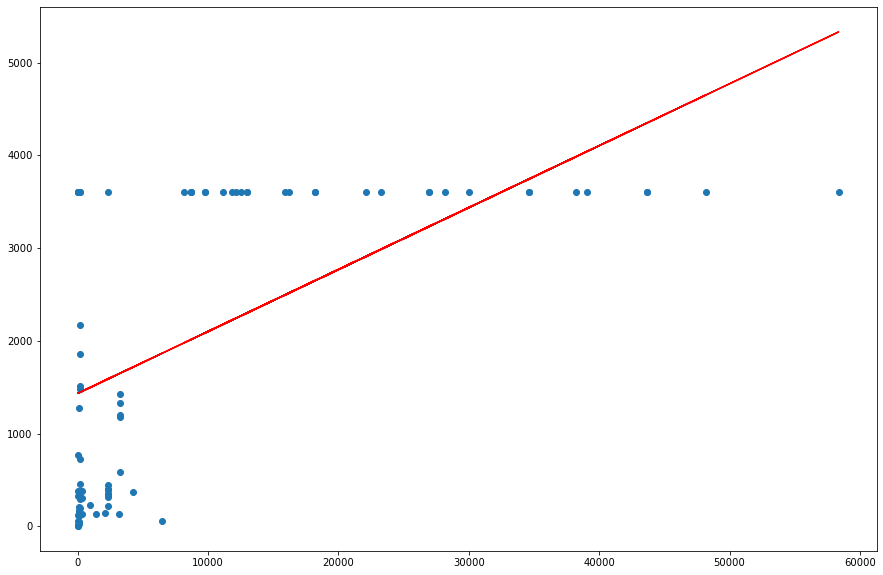

In [30]:
# constrains vs. time
fig = plt.figure(figsize=(15,10))
show_correlation_graph_time(1)

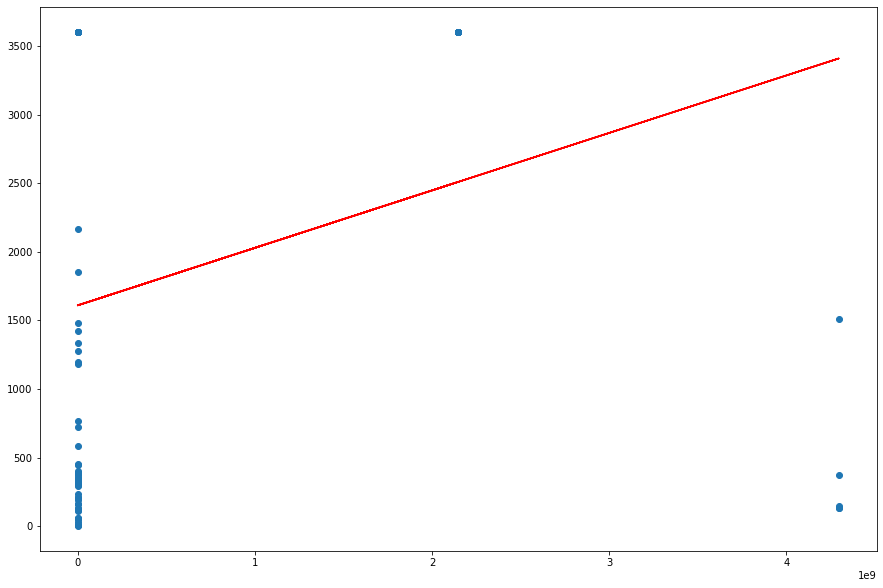

In [31]:
# b_max vs. time
fig = plt.figure(figsize=(15,10))
show_correlation_graph_time(3)

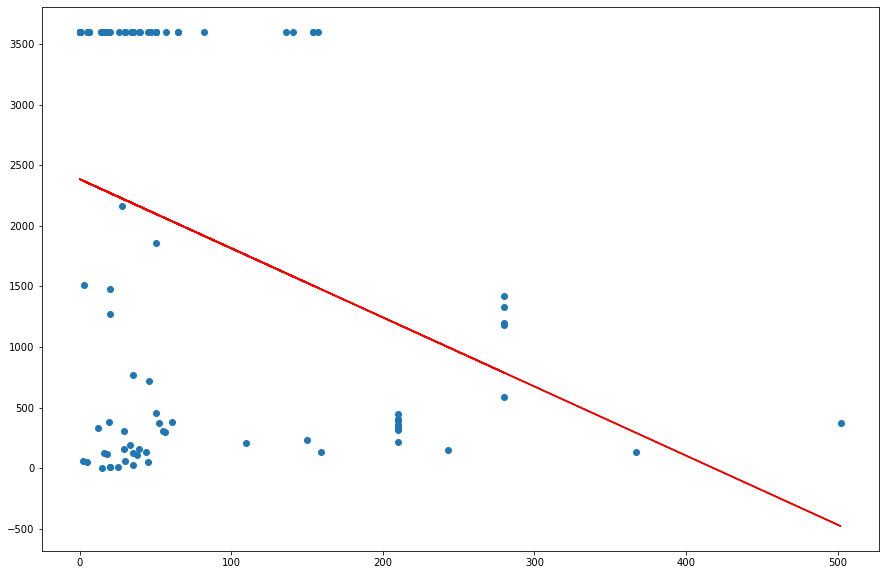

In [23]:
# k vs. time
fig = plt.figure(figsize=(15,10))
show_correlation_graph_time(4)

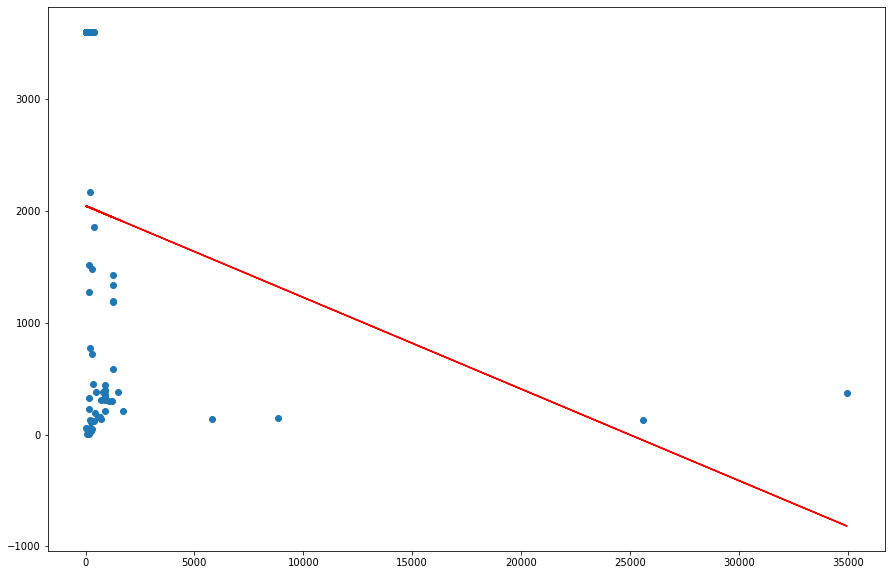

In [26]:
# bound vs. time
fig = plt.figure(figsize=(15,10))
show_correlation_graph_time(6)
plt.savefig('bound-v-time.jpg')